In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers, models, callbacks, regularizers, optimizers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, root_mean_squared_error
import seaborn as sns

# Import Daten

In [2]:
FILES = {
    'train': {
        'results': 'data/csv/train_race_results_2024.csv',
        'weather': 'data/csv/train_weather_2024.csv',
        'standings': 'data/csv/train_team_standings_2024.csv'
    },
    'test': {
        'results': 'data/csv/test_race_results_2025.csv',
        'weather': 'data/csv/test_weather_2025.csv',
        'standings': 'data/csv/test_team_standings_2025.csv'
    }
}
#Lädt Daten aus den csv-Datein und verknüpft sie in einem DataFrame
def load_and_merge_custom(file_dict):
    results = pd.read_csv(file_dict['results'])
    weather = pd.read_csv(file_dict['weather'])
    standings = pd.read_csv(file_dict['standings'])
    
    df = pd.merge(results, weather, on=['EventName', 'RoundNumber'], how='left')
    df = pd.merge(df, standings, on=['EventName', 'RoundNumber', 'TeamName', 'EventDate'], how='left')
    
    return df
train_df_raw = load_and_merge_custom(FILES['train'])
test_df_raw = load_and_merge_custom(FILES['test'])

# Daten Preprocessing

In [7]:
cols_to_drop = ['Status', 'RacePoints', 'DriverNumber', 'EventDate', 'RoundNumber']

train_df = train_df_raw.drop(columns=cols_to_drop)
test_df = test_df_raw.drop(columns=cols_to_drop)
categorical_columns = train_df.select_dtypes(include=['object']).columns.tolist()

#Kategoriale Spalten mit One-Hot Encoding in Zahlen umwandeln
train_df_encoded = pd.get_dummies(train_df, columns=categorical_columns, drop_first=True)
test_df_encoded = pd.get_dummies(test_df, columns=categorical_columns, drop_first=True)

target_col = 'Position'

#Position in einen einheitlichen Datentyp umwandeln
X_train_raw = train_df_encoded.drop(columns=target_col)
y_train = train_df_encoded[target_col].astype(float)

X_test_raw = test_df_encoded.drop(columns=target_col)
y_test = test_df_encoded[target_col].astype(float)

#Train und Test DataFrames angleichen
missing_cols = set(X_train_raw.columns) - set(X_test_raw.columns)

for c in missing_cols:
    X_test_raw[c] = 0

extra_cols = set(X_test_raw.columns) - set(X_train_raw.columns)
if extra_cols:
    X_test_raw = X_test_raw.drop(columns=extra_cols)

X_test_raw = X_test_raw[X_train_raw.columns]

#Daten skalieren
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train_raw)
X_test = scaler.transform(X_test_raw)

#GBR benötigt keinen split im Voraus
X_train_gbr = X_train.copy()
y_train_gbr = y_train.copy()

# X_train und y_train in train/val splitten, als Regularisierungsmaßnahme
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.15, random_state=42
)

# Multi-Layer-Perceptron Modell

In [8]:
def create_model(input_shape,
                 layer_sizes=[128, 64, 32],
                 dropout_rate=0.3,
                 l2_strength=0.001,
                 learning_rate=0.001,
                 activation='relu'):
    """
    Erstellt ein kompiliertes Keras-Modell mit flexibler Architektur.
    
    Parameter:
    - input_shape (int): Anzahl der Features (X_train.shape[1]).
    - layer_sizes (list): Liste mit Neuronen pro Schicht, z.B. [128, 64, 32].
    - dropout_rate (float): Wie viel Prozent der Neuronen ausgeschaltet werden.
    - l2_strength (float): Stärke der L2-Regularisierung (Lernbremse).
    - learning_rate (float): Geschwindigkeit des Adam Optimizers.
    """
    
    model = models.Sequential()
    
    # 1. Input Layer explizit definieren
    model.add(layers.Input(shape=(input_shape,)))
    
    # 2. Hidden Layers dynamisch aufbauen
    for i, units in enumerate(layer_sizes):
        # Dense Layer hinzufügen
        model.add(layers.Dense(
            units, 
            activation=activation, 
            kernel_regularizer=regularizers.l2(l2_strength)
        ))
        
        # Dropout hinzufügen bis auf den letzten Layer als Regularisierungsmaßnahme
        if i < len(layer_sizes) - 1: 
            model.add(layers.Dropout(dropout_rate))
            
    # 3. Output Layer (Immer 1 Neuron, Linear für Regression)
    model.add(layers.Dense(1, activation='linear'))
    
    # 4. Kompilieren
    model.compile(
        optimizer=optimizers.Adam(learning_rate=learning_rate),
        loss='mean_squared_error',
        metrics=['mean_absolute_error']
    )
    
    return model

def train_model(model, X_train, y_train, X_val, y_val,
                batch_size=32,
                epochs=300,
                patience=20,
                model_name='best_f1_model.keras'):
    """
    Trainiert das Modell mit standardisierten Callbacks.
    """
    
    # Callbacks konfigurieren
    callbacks_list = [
        # Stoppt Training, wenn keine Verbesserung mehr
        callbacks.EarlyStopping(
            monitor='val_loss',
            patience=patience,
            restore_best_weights=True,
            verbose=1
        ),
        # Reduziert Lernrate bei Plateau
        callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=int(patience/4),
            min_lr=0.00001,
            verbose=1
        ),
        # Speichert das beste Modell
        callbacks.ModelCheckpoint(
            filepath=model_name,
            monitor="val_loss",
            save_best_only=True,
            verbose=0
        ),
    ]
    
    print(f" Starte Training für '{model_name}'...")
    
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks_list,
        verbose=1
    )
    
    return history

In [9]:
input_dim = X_train.shape[1]

# GradientBoostingRegressor

In [10]:
gbr_model = GradientBoostingRegressor(n_estimators=200, learning_rate=0.05, max_depth=4, random_state=42)
gbr_model.fit(X_train_gbr, y_train_gbr)

,loss,'squared_error'
,learning_rate,0.05
,n_estimators,200
,subsample,1.0
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_depth,4
,min_impurity_decrease,0.0
,init,None


# Hilfsfunktionen Interpretation, Evaluierung und Vorhersage

In [11]:
def plot_training_history(history, model_name="Mein Modell"):
    """
    Zeichnet die Lernkurven (Loss und MAE) für ein trainiertes Modell.
    
    Parameter:
    - history: Das Rückgabe-Objekt von model.fit()
    - model_name: Ein Titel für die Grafik (um Modelle zu unterscheiden)
    """
    
    # Daten extrahieren
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    mae = history.history['mean_absolute_error']
    val_mae = history.history['val_mean_absolute_error']
    epochs = range(1, len(loss) + 1)

    # Grafik erstellen
    plt.figure(figsize=(14, 5))

    # --- Plot 1: MSE (Loss) ---
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss', linestyle='--')
    plt.title(f'{model_name} - Fehlerkurve (MSE)')
    plt.xlabel('Epochen')
    plt.ylabel('Mean Squared Error')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # --- Plot 2: MAE (Plätze) ---
    plt.subplot(1, 2, 2)
    plt.plot(epochs, mae, label='Training MAE')
    plt.plot(epochs, val_mae, label='Validation MAE', linestyle='--')
    plt.title(f'{model_name} - Fehler in Plätzen (MAE)')
    plt.xlabel('Epochen')
    plt.ylabel('Abweichung (Plätze)')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()
    
    # --- Zusammenfassung ausgeben ---
    best_epoch = np.argmin(val_mae)
    best_val_mae = val_mae[best_epoch]
    
    print(f"Bester Validation MAE für '{model_name}': {best_val_mae:.4f} (in Epoche {best_epoch + 1})")
    print("")
    print("")

In [12]:
def evaluate_model_predictions(model, X_test, y_test, model_name="Mein Modell", show_top_n=10):
    """
    Führt Vorhersagen durch, berechnet Fehler und visualisiert das Ergebnis.
    
    Returns:
        (loss, mae, results_df): Die Metriken und der Vergleichs-DataFrame.
    """
    print(f"--- Evaluierung für: {model_name} ---")
    
    # 1. Vorhersagen machen
    try:
        y_pred_raw = model.predict(X_test, verbose=0)
    except Exception as e:
        y_pred_raw = model.predict(X_test)

    y_pred_clipped = np.clip(y_pred_raw, 1, 20)
    
    y_pred_flat = y_pred_clipped.flatten()
    y_test_flat = y_test if isinstance(y_test, np.ndarray) else y_test.to_numpy()

    # 2. Metriken berechnen
    try:
        test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)
    except Exception as e:
        test_loss = mean_squared_error(y_test_flat, y_pred_flat)
        test_mae = mean_absolute_error(y_test_flat, y_pred_flat)
        
    print(f"Test Loss (MSE): {test_loss:.4f}")
    print(f"Test MAE: {test_mae:.4f} (Durchschnittlicher Fehler in Plätzen)")

    # 3. Grafik: Vorhersage vs. Realität
    plt.figure(figsize=(10, 6))
    
    # Scatter Plot
    plt.scatter(y_test_flat, y_pred_flat, alpha=0.6, color='blue', label='Vorhersagen')
    
    # Die "Perfekte Linie" (y = x)
    min_val = min(y_test_flat.min(), y_pred_flat.min())
    max_val = max(y_test_flat.max(), y_pred_flat.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfekt')
    
    plt.xlabel('Tatsächliche Position')
    plt.ylabel('Vorhergesagte Position')
    plt.title(f'{model_name}: Vorhersage vs. Realität')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    # 4. Vergleichstabelle erstellen
    comparison_df = pd.DataFrame({
        'Tatsächlich': y_test_flat,
        'Vorhergesagt (Roh)': np.round(y_pred_flat, 2),
        'Vorhergesagt (Rund)': np.clip(np.round(y_pred_flat), 1, 20).astype(int),
        'Fehler (Absolut)': np.abs(y_test_flat - y_pred_flat)
    })
        
    return test_loss, test_mae, comparison_df

In [13]:
def show_race_predictions(model, X_test, original_df):
    """
    Erstellt eine Tabelle mit den vorhergesagten Platzierungen für jedes Rennen.
    
    Args:
        model: Das trainierte Keras-Modell.
        X_test: Die skalierten Testdaten (Features).
        original_df: Der DataFrame mit den Metadaten (Fahrer, Event, etc.), 
                     der zu X_test gehört (z.B. test_df_raw).
    """
    
    # 1. Vorhersagen machen (Rohwerte)
    try:
        raw_preds = model.predict(X_test, verbose=0).flatten()
    except Exception as e:
        raw_preds = model.predict(X_test).flatten()
    
    # 2. Ergebnisse in eine Kopie des Original-DataFrames schreiben
    results = original_df.copy()
    
    # Den Rohwert speichern
    results['Score_Raw'] = raw_preds
    
    # Den gerundeten Platz speichern
    # Wir clippen auf 1-20, da das neuronale Netz manchmal nicht existente Platzierungen belegt
    results['Predicted_Position'] = np.clip(np.round(raw_preds), 1, 20).astype(int)
    
    # 3. Fehler berechnen
    if 'Position' in results.columns:
        results['Real_Position'] = results['Position']
        results['Diff'] = results['Predicted_Position'] - results['Real_Position']
    
    # 4. SORTIERUNG
    # Wir sortieren erst nach Rennen, und DANN nach dem Score.
    # Der Fahrer mit dem niedrigsten Score ist unser Platz 1.
    final_table = results.sort_values(by=['EventName', 'Score_Raw'], ascending=[True, True])
    
    # 5. Platzierung im Rennen neu berechnen (Rank)
    # Manchmal sagt das Modell für zwei Fahrer "1" voraus (z.B. 1.2 und 1.4).
    # Durch den Rank machen wir daraus Platz 1 und Platz 2 basierend auf dem Rohwert.
    final_table['Model_Rank'] = final_table.groupby('EventName')['Score_Raw'].rank(method='first').astype(int)
    
    # 6. Spalten für die Ausgabe auswählen
    cols_to_show = ['EventName', 'Model_Rank', 'Predicted_Position', 'Abbreviation', 'TeamName']
    if 'Real_Position' in results.columns:
        cols_to_show.extend(['Real_Position', 'Diff'])
        
    return final_table[cols_to_show]

# Hyperparameter-Tuning durch Try-and-Fail

In [ ]:
model_v1 = create_model(input_shape=input_dim, layer_sizes=[128, 64, 32], dropout_rate=0.3, l2_strength=0.001, learning_rate=0.001)
history_v1 = train_model(model_v1, X_train, y_train, X_val, y_val, model_name="f1_model_standard.keras")
plot_training_history(history_v1, model_name="Modell V1")
loss_v1, mae_v1, df_v1 = evaluate_model_predictions(model_v1, X_test ,y_test, model_name="Modell V1")

model_v2 = create_model(input_dim, layer_sizes=[256, 128, 64], dropout_rate=0.5, learning_rate=0.00005)
history_v2 = train_model(model_v2, X_train, y_train, X_val, y_val, model_name="model_v2.keras")
plot_training_history(history_v2, model_name="Modell V2")
loss_v2, mae_v2, df_v2 = evaluate_model_predictions(model_v2, X_test, y_test, model_name="Modell V2")

model_v3 = create_model(input_dim, layer_sizes=[512 ,256, 128, 64], dropout_rate=0.5, learning_rate=0.00005)
history_v3 = train_model(model_v3, X_train, y_train, X_val, y_val, model_name="model_v3.keras")
plot_training_history(history_v3, model_name="Modell V3")
loss_v3, mae_v3, df_v3 = evaluate_model_predictions(model_v3, X_test, y_test, model_name="Modell V3")

model_v4 = create_model(input_dim, layer_sizes=[64, 32], dropout_rate=0.2, l2_strength=0.01)
history_v4 = train_model(model_v4, X_train, y_train, X_val, y_val, model_name="model_v4.keras")
plot_training_history(history_v4, model_name="Modell V4")
loss_v4, mae_v4, df_v4 = evaluate_model_predictions(model_v4, X_test, y_test, model_name="Modell V4")

model_v6 = create_model(input_dim, layer_sizes=[64, 32], dropout_rate=0.2, l2_strength=0.001, learning_rate=0.0001)
history_v6 = train_model(model_v6, X_train, y_train, X_val, y_val, model_name="model_v6.keras")
plot_training_history(history_v6, model_name="Modell V6")
loss_v6, mae_v6, df_v6 = evaluate_model_predictions(model_v6, X_test, y_test, model_name="Modell V6")

model_v7 = create_model(input_dim, layer_sizes=[64, 32], dropout_rate=0.2, l2_strength=0.001, learning_rate=0.01)
history_v7 = train_model(model_v7, X_train, y_train, X_val, y_val, model_name="model_v7.keras")
plot_training_history(history_v7, model_name="Modell V7")
loss_v7, mae_v7, df_v7 = evaluate_model_predictions(model_v7, X_test, y_test, model_name="Modell V7")

# Bestes Neural-Network-Modell nach MSE

 Starte Training für 'model_v5.keras'...
Epoch 1/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 122.1293 - mean_absolute_error: 9.3869 - val_loss: 132.5712 - val_mean_absolute_error: 9.9886 - learning_rate: 0.0010
Epoch 2/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 98.6507 - mean_absolute_error: 8.2641 - val_loss: 105.6791 - val_mean_absolute_error: 8.7276 - learning_rate: 0.0010
Epoch 3/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 75.3892 - mean_absolute_error: 7.0825 - val_loss: 76.2915 - val_mean_absolute_error: 7.2870 - learning_rate: 0.0010
Epoch 4/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 49.9120 - mean_absolute_error: 5.6537 - val_loss: 46.8149 - val_mean_absolute_error: 5.6172 - learning_rate: 0.0010
Epoch 5/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 30.5562 - mean_absolute_error: 4.3338 - val_loss: 24.2147 - val_mean_absolute_error: 3.9036 - learning_rate: 0.0010
Epoch 6/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 18.2439 - mean_absolut

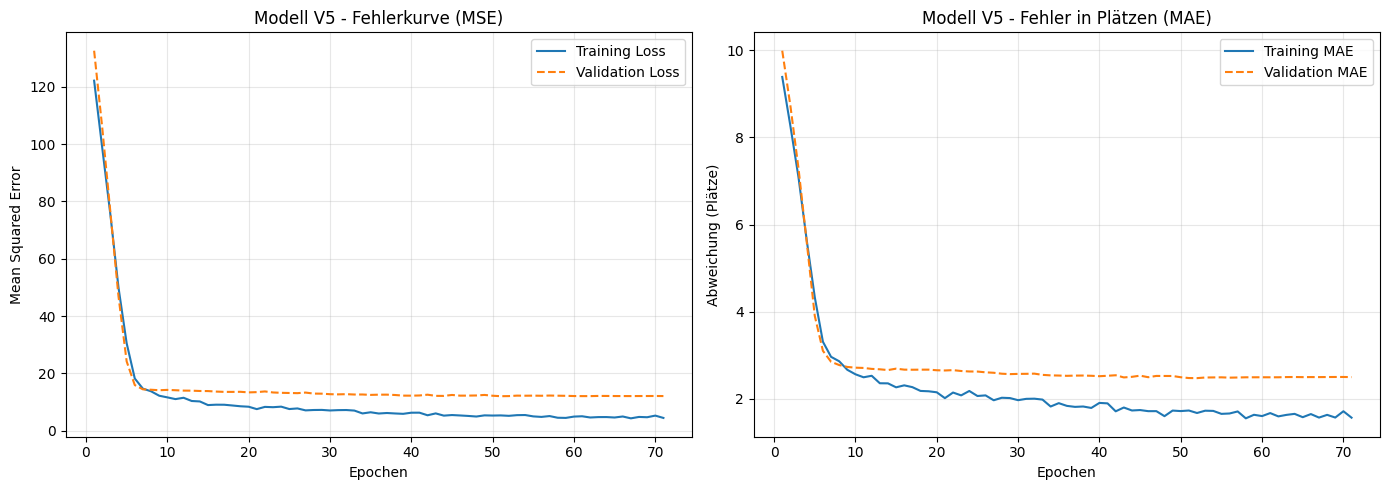

Bester Validation MAE für 'Modell V5': 2.4752 (in Epoche 52)




In [14]:
model_v5 = create_model(input_dim, layer_sizes=[64, 32], dropout_rate=0.2, l2_strength=0.001)

history_v5 = train_model(model_v5, X_train, y_train, X_val, y_val, model_name="model_v5.keras")

plot_training_history(history_v5, model_name="Modell V5")

# Vorhersage MLP-Modell

--- Evaluierung für: Multi-Layer-Perception-Model ---
Test Loss (MSE): 17.0735
Test MAE: 3.0737 (Durchschnittlicher Fehler in Plätzen)


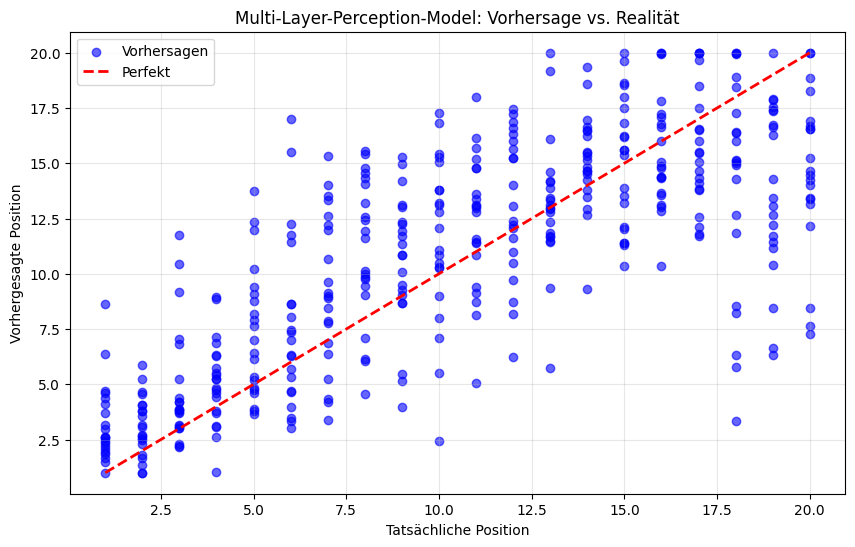

In [15]:
race_results_mlp = show_race_predictions(model_v5, X_test, test_df)
loss_mlp, mae_mlp, df_mlp = evaluate_model_predictions(model_v5, X_test, y_test, model_name="Multi-Layer-Perception-Model")

# Nach den Ergebnissen eines einzelnen Rennens suchen
# monaco_df = race_results_mlp[race_results_mlp['EventName'].str.contains("Monaco", case=False)]
# print(monaco_df.sort_values('Predicted_Position').to_markdown(index=False))

# Vorhersage GradientBoostingRegression

--- Evaluierung für: GradientBoostingRegression ---
Test Loss (MSE): 11.9167
Test MAE: 2.5574 (Durchschnittlicher Fehler in Plätzen)


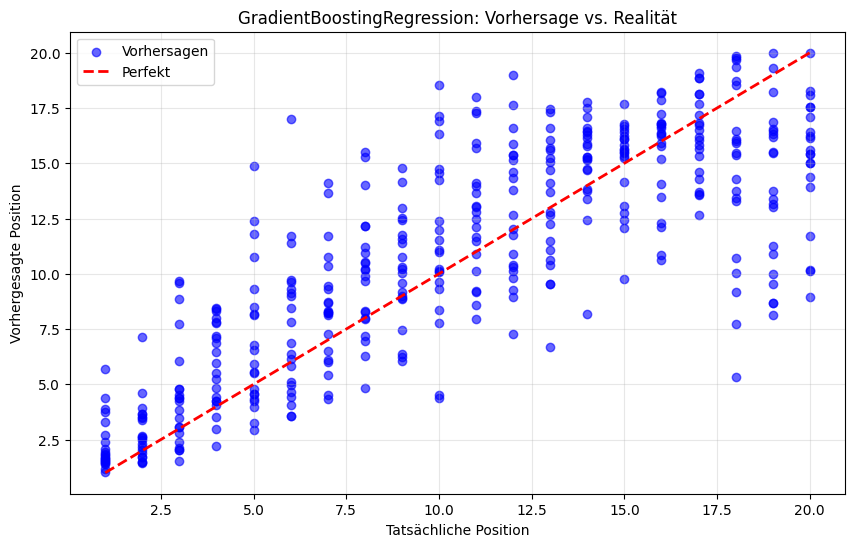

In [16]:
race_results_gbr = show_race_predictions(gbr_model, X_test, test_df)
loss_gbr, mae_gbr, df_gbr = evaluate_model_predictions(gbr_model, X_test, y_test, model_name="GradientBoostingRegression")

# Vergleich Multi-Layer-Perceptron und GradientBoostingRegressor

In [17]:
def get_detailed_metrics(y_true, y_pred, model_name="Modell"):
    # Sicherstellen, dass alles 1D-Arrays sind
    y_true = np.array(y_true).flatten()
    y_pred = np.array(y_pred).flatten()
    
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = root_mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    print(f"--- Metriken für {model_name} ---")
    print(f"MAE (Fehler in Plätzen): {mae:.4f}")
    print(f"MSE (Fehler²):           {mse:.4f}")
    print(f"RMSE (Fehler):           {rmse:.4f}")
    print(f"R² (Erklärte Varianz):   {r2:.4f} (Max: 1.0)")
    
    return {"MAE": mae, "MSE": mse, "R2": r2, "RMSE": rmse}

gbr_model.fit(X_train, y_train) # Nutzt dieselben Daten wie dein NN!

# 2. Vorhersagen machen
y_pred_gbr = gbr_model.predict(X_test)

# 3. Vorhersagen deines besten NNs holen (z.B. Modell V5)
# Wichtig: .flatten() nutzen, da Keras [[1], [2]] ausgibt, sklearn aber [1, 2] will
y_pred_nn = model_v5.predict(X_test, verbose=0).flatten()

# 4. Vergleich der Metriken
metrics_nn = get_detailed_metrics(y_test, y_pred_nn, "Neural Network")
print("")
metrics_gbr = get_detailed_metrics(y_test, y_pred_gbr, "Gradient Boosting")

--- Metriken für Neural Network ---
MAE (Fehler in Plätzen): 3.0737
MSE (Fehler²):           16.9455
RMSE (Fehler):           4.1165
R² (Erklärte Varianz):   0.4883 (Max: 1.0)

--- Metriken für Gradient Boosting ---
MAE (Fehler in Plätzen): 2.5299
MSE (Fehler²):           11.6814
RMSE (Fehler):           3.4178
R² (Erklärte Varianz):   0.6472 (Max: 1.0)


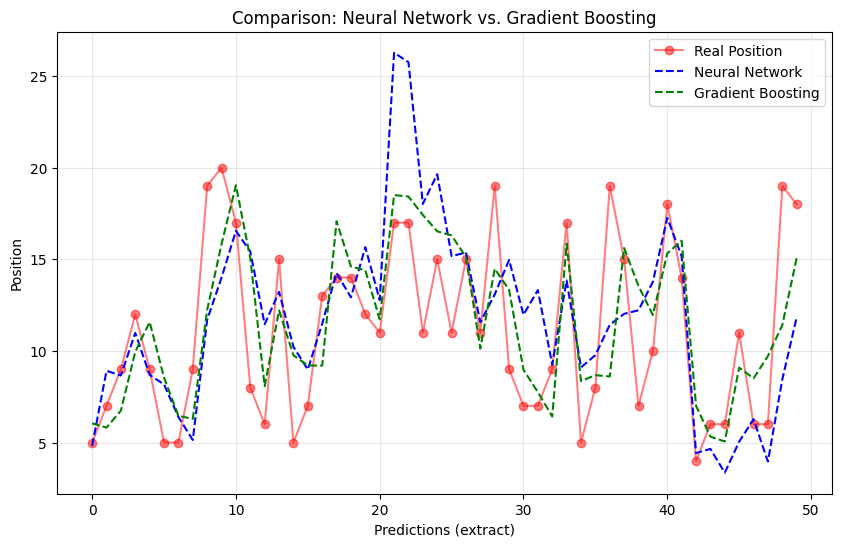

In [18]:
def plot_model_comparison(y_test, pred_nn, pred_gbr):
    plt.figure(figsize=(10, 6))
    
    limit = 50
    x_ax = range(limit)
    
    plt.plot(x_ax, y_test[:limit], label="Real Position", color="red", linestyle="-", marker="o", alpha=0.5)
    plt.plot(x_ax, pred_nn[:limit], label="Neural Network", color="blue", linestyle="--")
    plt.plot(x_ax, pred_gbr[:limit], label="Gradient Boosting", color="green", linestyle="--")
    
    plt.title("Comparison: Neural Network vs. Gradient Boosting")
    plt.xlabel("Predictions (extract)")
    plt.ylabel("Position")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

plot_model_comparison(y_test, y_pred_nn, y_pred_gbr)